In [1]:
# environment
import os
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

# data manipulation
import re
import numpy as np
import pandas as pd

# image processing
import cv2 as cv
from PIL import Image
from scipy import ndimage as ndi
from skimage import io, transform, morphology, img_as_bool, segmentation
from skimage.util.shape import view_as_blocks

# plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Prepare Dataset

In [2]:
api = KaggleApi()
api.authenticate()

data_filename = 'bms-molecular-translation.zip'

# get data from kaggle
if not os.path.exists(data_filename):
    api.competition_download_files(data_filename)

In [3]:
# file path info
root_dir  = 'E:\\kaggle\\bms'
data_dir  = os.path.join(root_dir, 'data')
train_dir = os.path.join(data_dir, 'train')
train_csv = os.path.join(data_dir, 'train.csv')
label_csv = os.path.join(data_dir, 'train_labels.csv')

# data dimensionality
img_width  = 224
img_height = 224

In [4]:
if not os.path.exists(train_csv):
    # load dataframe
    train_df = pd.read_csv(train_csv)

else:
    # create and clean image df
    train_df = (
        pd.read_csv(label_csv)
          .rename(columns=str.lower)
          .assign(inchi_simple=lambda x: x.inchi.apply(
              lambda y: '/'.join(y.split('/', 2)[:2])
           ))
          .assign(image_path=lambda x: x.image_id.apply(
              lambda y: os.path.join(train_dir, y[0], y[1], y[2], y+'.png')
           ))
    )

    # save to csv
    train_df.to_csv(train_csv, index=False)

In [5]:
train_df.sample(10)

,image_id,inchi,inchi_simple,image_path
87617,093f26aeac41,InChI=1S/C15H17ClN2O/c1-2-6-19-15-9-12(17)8-14...,InChI=1S/C15H17ClN2O,E:\kaggle\bms\data\train\0\9\3\093f26aeac41.png
2063571,d9ce30c2c95a,InChI=1S/C22H27NO3S2/c1-4-16(3)28-18-9-10-19(1...,InChI=1S/C22H27NO3S2,E:\kaggle\bms\data\train\d\9\c\d9ce30c2c95a.png
1516031,a00e223c9eb5,InChI=1S/C14H16ClN3/c1-18(9-11-4-2-3-5-14(11)1...,InChI=1S/C14H16ClN3,E:\kaggle\bms\data\train\a\0\0\a00e223c9eb5.png
908783,5fe1fad74e9e,InChI=1S/C23H26N2O3S/c1-4-5-12-25-22(26)19(24-...,InChI=1S/C23H26N2O3S,E:\kaggle\bms\data\train\5\f\e\5fe1fad74e9e.png
1255603,847ee9b7276b,InChI=1S/C14H19NO3/c1-9-10(2)12(18-3)5-4-11(9)...,InChI=1S/C14H19NO3,E:\kaggle\bms\data\train\8\4\7\847ee9b7276b.png
1536354,a2308d0b574a,InChI=1S/C15H28N2O2/c1-7-11(6)12-15(19)17(8-9(...,InChI=1S/C15H28N2O2,E:\kaggle\bms\data\train\a\2\3\a2308d0b574a.png
1077044,71a8e8e383bd,InChI=1S/C24H19N3O5S2/c1-30-18-11-6-10-17(24(1...,InChI=1S/C24H19N3O5S2,E:\kaggle\bms\data\train\7\1\a\71a8e8e383bd.png
2167304,e4ce555bc05f,InChI=1S/C21H20ClF3N4O/c22-19-13-17(5-4-15(19)...,InChI=1S/C21H20ClF3N4O,E:\kaggle\bms\data\train\e\4\c\e4ce555bc05f.png
2212522,e9a221e42c9e,"InChI=1S/C20H30FN3O2/c1-5-20(6-2,19(26)23-4)17...",InChI=1S/C20H30FN3O2,E:\kaggle\bms\data\train\e\9\a\e9a221e42c9e.png
1535286,a213bd97210c,"InChI=1S/C25H27F6N3O2/c26-24(27,28)20-8-7-19(2...",InChI=1S/C25H27F6N3O2,E:\kaggle\bms\data\train\a\2\1\a213bd97210c.png


## Example Images

In [6]:
def pad_to_square(img):
    """
    Pads grayscale image with zeros until square-shaped.
    """
    m, n = img.shape
    n_pad = abs(m-n) // 2
    if m > n:
        padding = ((0, 0), (n_pad, n_pad))
    else:
        padding = ((n_pad, n_pad), (0, 0))
    return np.pad(img, padding, mode='constant')

In [7]:
def invert(img):
    """
    Inverts grayscale image.
    """
    return 255 - img

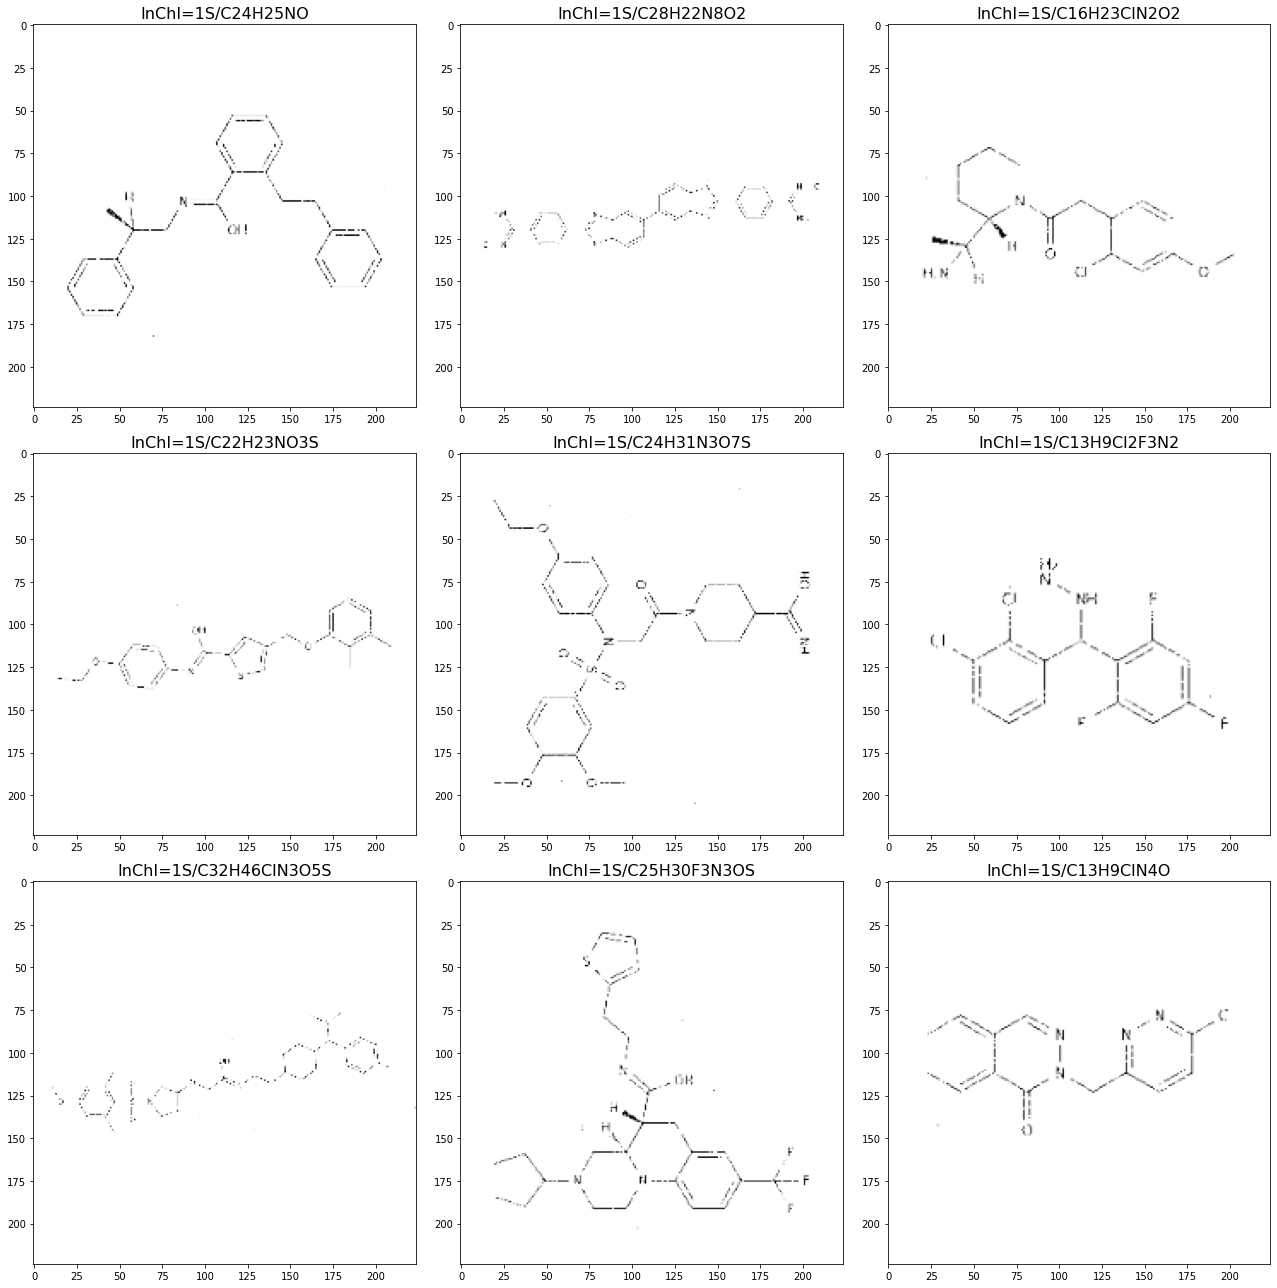

In [8]:
rows = 3
cols = 3

sample = train_df.sample(rows*cols)

# define subplot arrangement
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(18, 18))

# kernel = np.ones((2, 2))

for i, (idx, _) in enumerate(sample.iterrows()):
    img_path = sample.at[idx, 'image_path']
    inchi_simple = sample.at[idx, 'inchi_simple']

    # load, square, invert
    img = io.imread(img_path)
    img = pad_to_square(invert(img))
    
    # transform
    # if img.shape[0] > 1.50 * img_width:
    #     img = cv.dilate(img, kernel)
    #     img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
        
    img = cv.resize(img, (img_width, img_height))

    # plot sample image
    ax = fig.add_subplot(gs[i])
    ax.imshow(img, cmap='Greys')
    ax.set_title(inchi_simple, fontsize=16)
    
plt.tight_layout()
plt.show()

## Extract Tokens

#### Simple Chemical Tokens

In [9]:
# ignore prefix (InChI=1S/)
simple_labels = [s.split('/')[1] for s in train_df.inchi_simple]

# extract tokens (elements and numbers)
tokens = [t for s in simple_labels for t in re.findall('(\d+|[A-Z][a-z]*)', s)]
tokens = sorted(list(set(tokens)), reverse=True)

In [10]:
print(tokens)

['Si', 'S', 'P', 'O', 'N', 'I', 'H', 'F', 'Cl', 'C', 'Br', 'B', '99', '98', '97', '96', '95', '94', '93', '92', '91', '90', '9', '89', '88', '87', '86', '85', '84', '83', '82', '81', '80', '8', '79', '78', '77', '76', '75', '74', '73', '72', '71', '70', '7', '69', '68', '67', '66', '65', '64', '63', '62', '61', '60', '6', '59', '58', '57', '56', '55', '54', '53', '52', '51', '50', '5', '49', '48', '47', '46', '45', '44', '43', '42', '41', '40', '4', '39', '38', '37', '36', '35', '34', '33', '32', '31', '30', '3', '29', '28', '27', '26', '25', '24', '23', '22', '21', '20', '2', '19', '18', '17', '167', '165', '163', '161', '16', '159', '158', '157', '156', '155', '154', '153', '152', '151', '150', '15', '149', '148', '147', '146', '145', '144', '143', '142', '141', '140', '14', '139', '138', '137', '136', '135', '134', '133', '132', '131', '130', '13', '129', '128', '127', '126', '125', '124', '123', '122', '121', '120', '12', '119', '118', '117', '116', '115', '114', '113', '112', '111

In [11]:
# include missing numbers
tokens_simple = ['<START>', '<PAD>', '<END>', 'InChI=1S/']    \
              + tokens[:12] + [str(i) for i in range(1, 168)]

In [12]:
print(tokens_simple)

['<START>', '<PAD>', '<END>', 'InChI=1S/', 'Si', 'S', 'P', 'O', 'N', 'I', 'H', 'F', 'Cl', 'C', 'Br', 'B', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '

#### Full Chemical Tokens

In [13]:
# additional tokens present in full formulas
add_tokens = [t for s in train_df.inchi for t in re.findall('/[a-z]', s)]
add_tokens = list(set(add_tokens)) + ['D', 'T', '+', '-', ',']

In [14]:
print(add_tokens)

['/c', '/i', '/t', '/m', '/b', '/s', '/h', 'D', 'T', '+', '-', ',']


In [15]:
tokens_full = tokens_simple[:-3] + add_tokens + tokens_simple[-3:]

In [16]:
print(tokens_full)

['<START>', '<PAD>', '<END>', 'InChI=1S/', 'Si', 'S', 'P', 'O', 'N', 'I', 'H', 'F', 'Cl', 'C', 'Br', 'B', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '